# Exercises

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

In [48]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns

In [49]:
# Load ROI file 
input_tif_file_path = 'Desktop/neuroanalysis/neural-data-master/02-calcium_imaging/data/caiman_video_trial_0.tif'  

# Define parameters for motion correction in a dictionary
parameters_motion_correction = { 'pw_rigid': True,       # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 
                                'use_cuda': False, 
                                'nonneg_movie': True,
                                'border_nan': 'copy'
                                }


original_movie = cm.load(input_tif_file_path)
parameters_motion_correction['min_mov'] = np.min(original_movie) 

# Pass parameters to caiman object
opts = params.CNMFParams(params_dict = parameters_motion_correction)

In [50]:
# Create an object for motion correction 
mc = MotionCorrect(input_tif_file_path, dview = None, **opts.get_group('motion'))

# Perform rigid motion correction
mc.motion_correct_rigid(save_movie = True, template = None)
mc_file_path = mc.fname_tot_rig

In [51]:
# Load motion corrected video
input_mmap_file_path = 'Desktop/neuroanalysis/neural-data-master/02-calcium_imaging/data/motion_corrected/caiman_video_trial_0_rig__d1_300_d2_400_d3_1_order_F_frames_500.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

In [52]:
# Select number of N random pixels
N = 10

# Get the dimensions of the ROI 
dimensions = images.shape[1:]

# Generate the N random pixel coordinates
x_coords = np.random.randint(0, dims[1], N)
y_coords = np.random.randint(0, dims[0], N)

# Get the pixel values for the N selected pixels for all frames
pixel_values = images[:, y_coords, x_coords]

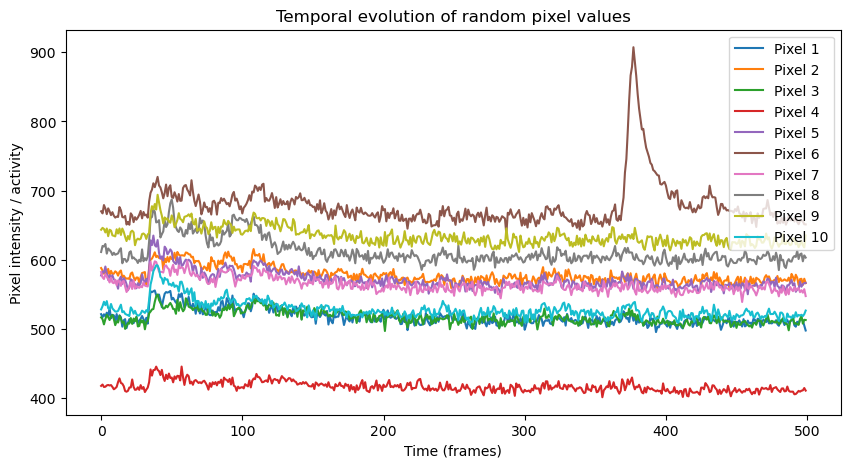

In [53]:
# Plot the temporal evolution of these pixel values
plt.figure(figsize=(10, 5))
for i in range(N):
    plt.plot(pixel_values[:, i], label=f'Pixel {i+1}')
plt.xlabel('Time (frames)')
plt.ylabel('Pixel intensity / activity')
plt.title('Temporal evolution of random pixel values')
plt.legend()
plt.show()

### Comments Exercise 1A: 
To analyse the temporal evolution of pixel values in the ROI, first a motion correction is done. In the above plot it is possible to see one randomly selected pixel that is from an active neuron (pixel 6), as can be seen due to the spike in activity with an intensity of above 800. 

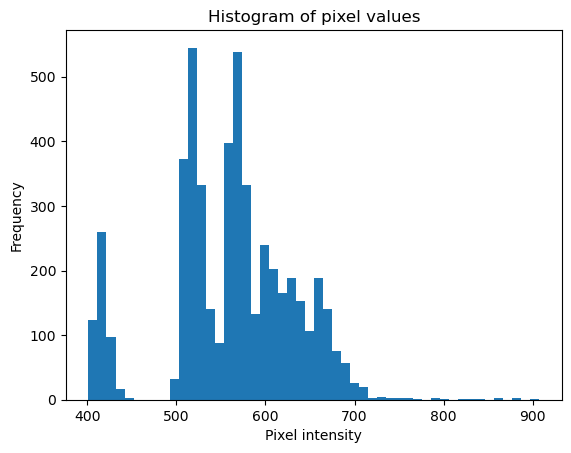

In [60]:
# Flatten the random pixel values for histogram
flatten_pixels = pixel_values.flatten()

# Plot the histogram for the random selected pixel values from ROI
plt.hist(flatten_pixels, bins=50)
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.title('Histogram of pixel values')
plt.show()

### Comments Exercise 1B: 
When looking at the histogram of the randomly selected pixels, it can be seen that most pixels have an intensity lower than 700. The lower pixel intensity means that this pixel will probably belong to the background. The higher the pixel intensity, the higher the chance it belongs to a neuron. Because most pixels will indeed be background pixels (especially when randomly selected) it is logical that the low intensity pixels are more frequenct in comparison to the higher intensity neuron pixels. 

Although individual pixels show (a change in) intensity, from which the calcium traces could be derived, it is still necessary to use source extraction to segment the neurons. With the source extraction we isolate the temporal activity individual neurons. These neurons consists of multiple pixels and individual pixels are more prone to noise when looking at the temporal traces. By isolating the neurons, the noise can be reduced as it is not dependent on individual pixels. Furthermore, it is better to do source extraction as this can deal with overlapping sources. It is possible that some neurons overlap in the imaging viewpoint and thus individual pixels could also overlap and can be part of two neurons, which would not be noticed if the neurons are not separated. 

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.